#### Prerequesites:
* Define schema (make figure) 
* Define structure (make figure)
* Define schema class in python (src/models/model_schemata.py)
* Convert schema + structure into model template (models/templates/p_model.pl)

#### Procedure:
* Load data
* Adjust model script for lfi accordingly
* Create evidence file (if I don't need different evidence files, move to builmodel notebook)
* LFI

Multiple instances, 1 pst, 3 enzymes, one sample per instance, test how many instances can have, how computing time depends on N instances

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Importing libraries
import pandas as pd
import numpy as np
import os
import random

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns

from src.models import model_schemata as schema
from src.models import build_model as build
from src.visualization import visualize as viz

In [5]:
os.chdir('/Users/magdalena/OneDrive - Queen Mary, University of London/bezzlab/research/projects/phospho_pi/')
# os.chdir('/home/mhuebner/Desktop/bezzlab/research/projects/phospho_pi/')

#### Training/Testing

In [4]:
# reading csv from files into dict
data = {}
data['e_activity'] = pd.read_csv('data/processed/synthetic_data/toy_network_mini/p_model/e_activity.csv')
data['p_occupancy'] = pd.read_csv('data/processed/synthetic_data/toy_network_mini/p_model/p_occupancy.csv')
data['e_activity']

,enzyme,sample,value,prob
0,e1,s1,inc,0.774553
1,e1,s10,dec,0.617971
2,e1,s100,inc,0.796040
3,e1,s11,base,0.650127
4,e1,s12,dec,0.748834
...,...,...,...,...
295,e3,s95,inc,0.644811
296,e3,s96,inc,0.550137
297,e3,s97,inc,0.812202
298,e3,s98,dec,0.783041


Splitting data into training/testing

In [5]:
# getting sample names (union of all samples in all datasets)
samples = list(set(data['e_activity']['sample']).union(set(data['p_occupancy']['sample'])))
samples.sort()
# sample x% of samples randomly without replacement with seed
random.seed(612)
train = random.sample(samples, int(len(samples)*0.2))
# train = ['s1', 's2', 's3']
# filter data
training_data = {}
training_data['e_activity'] = data['e_activity'][data['e_activity']['sample'].isin(train)].reset_index(drop=True)
training_data['p_occupancy'] = data['p_occupancy'][data['p_occupancy']['sample'].isin(train)].reset_index(drop=True)

In [6]:
# Mapping data to Problog predicates
predicates = {}
predicates['e_ksea'] = schema.EKseaPredicate()
predicates['e_ksea'].add_data(training_data['e_activity'], 'enzyme', 'sample', 'value')
predicates['p_fc'] = schema.PFoldChangePredicate()
predicates['p_fc'].add_data(training_data['p_occupancy'], 'phosphosite', 'sample', 'value')

In [7]:
samples = list(set(training_data['e_activity']['sample']).union(set(training_data['p_occupancy']['sample'])))
evidence_dict = {}
for s in samples:
    evidence = []
    for predicate in predicates:
        evid_generator = build.ProblogStatementGenerator(predicates[predicate])
        evidence = evidence + evid_generator.generate_facts(build.EvidenceTemplate, select=[s])
    evidence_dict[s] = evidence

In [16]:
# write evidence_dict to text file: loop over samples and separate by line of hyphens
with open('models/synthetic_data/toy_network_mini/p_model/evidence_o1.pl', 'w') as f:
    for s in evidence_dict:
        for e in evidence_dict[s]:
            f.write(e + '\n')
        f.write('--------------------' + '\n')

LFI

In [ ]:
DIR = 'models/synthetic_data/toy_network_mini/p_model/'
max_iter = 3
# learning from interpretation
cmd = f'problog lfi {DIR}p_model_lfi_o1.pl {DIR}evidence_o1.pl -O {DIR}p_model_o1.pl -k ddnnf -v -n {max_iter}'
os.system(cmd)

Grounding

In [8]:
DIR = 'models/synthetic_data/toy_network_mini/p_model/'
# learning from interpretation
cmd = f'problog ground {DIR}p_model_lfi_o1.pl -o {DIR}p_model_o1_ground.pl --format pl'
os.system(cmd)

(True, 't(0.33,e1,s79)::e_activity(e1,s79,base); t(0.33,e1,s79)::e_activity(e1,s79,dec); t(0.33,e1,s79)::e_activity(e1,s79,inc).\n0.9105218665::e_ksea(e1,s79,base) :- e_activity(e1,s79,base).\n0.0794781335::e_ksea(e1,s79,base) :- e_activity(e1,s79,dec).\n0.0794781335::e_ksea(e1,s79,base) :- e_activity(e1,s79,inc).\nt(0.33,e2,s79)::e_activity(e2,s79,base); t(0.33,e2,s79)::e_activity(e2,s79,dec); t(0.33,e2,s79)::e_activity(e2,s79,inc).\n0.1432501803::e_ksea(e2,s79,inc) :- e_activity(e2,s79,base).\n0.001::e_ksea(e2,s79,inc) :- e_activity(e2,s79,dec).\n0.7124996395::e_ksea(e2,s79,inc) :- e_activity(e2,s79,inc).\nt(0.33,e3,s79)::e_activity(e3,s79,base); t(0.33,e3,s79)::e_activity(e3,s79,dec); t(0.33,e3,s79)::e_activity(e3,s79,inc).\n0.768775166::e_ksea(e3,s79,base) :- e_activity(e3,s79,base).\n0.221224834::e_ksea(e3,s79,base) :- e_activity(e3,s79,dec).\n0.221224834::e_ksea(e3,s79,base) :- e_activity(e3,s79,inc).\nt(0.7,e1,p0)::occ_dec(p0,s79) :- e_activity(e1,s79,dec).\nt(0.7,e2,p0)::occ_de

256

Analysis

In [6]:
# DONE add to csv file for model training
n_evidence = np.array([4, 4, 4, 4, 4, 4, 4, 4])
n_pfacts = np.array([36, 36, 36, 36, 36, 36, 36, 36])
n_pfacts_e = np.array([40, 40, 40, 40, 40, 40, 40, 40])
n_params = np.array([58, 58, 58, 58, 58, 58, 58, 58])
n_pfacts_cross = np.array([17, 17, 17, 17, 17, 17, 17, 17])
n_params_cross = np.array([33, 33, 33, 33, 33, 33, 33, 33])
n_samples = np.array([1, 2, 3, 5, 10, 20, 50, 80])
n_inst = np.array([1, 2, 3, 5, 10, 20, 50, 80])
t_compile = np.array([0.422346, 0.550336, 0.555902, 0.725704, 1.063860, 1.759076, 3.770566, 5.647475])
t_total = np.array([1.2, 1.8, 2.4, 3.5, 6.6, 12.9, 31.0, 53.7])
t_eval = t_total - t_compile

Plot A

In [7]:
x_features_a = {'Compilation': n_inst, 'Evaluation': n_inst, 'Total': n_inst}
y_time_a = {'Compilation': t_compile, 'Evaluation': t_eval, 'Total': t_total}
# viz.plot_multiple_time_lin(x_features, y_time, 'Number of instances', 'Time [s]', 60000, title=None)

Predicted y-value for x = 60000: 3974.853007113246s = 66.2475501185541min = 1.104125835309235h
Predicted y-value for x = 60000: 35258.39106351089s = 587.6398510585149min = 9.793997517641914h
Predicted y-value for x = 60000: 39233.24407075499s = 653.8874011792499min = 10.898123352987497h


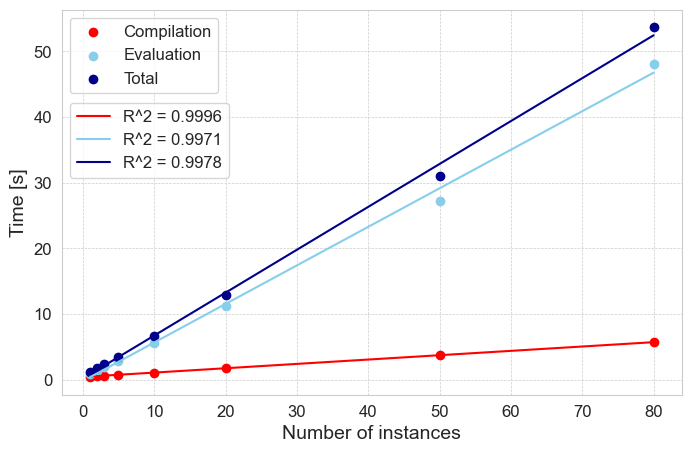

In [8]:
def plot_multiple_time_lin_a(x_dict, y_data_dict, x_label, y_label, x_predict, title = 'Linear Fit'):
    
    # Define the linear function you want to fit
    def linear_func(x, a, b):
        return a * x + b

    sns.set_style('whitegrid')
    plt.figure(figsize=(8, 5), dpi=100)  # Create a larger figure for better visualization

    colors = ['red', 'skyblue', 'darkblue']
    
    custom_labels = []
    custom_handles = []
    
    for i, (key, x_data) in enumerate(x_dict.items()):
        
        y_data = y_data_dict[key]
        # Fit the linear function to the data
        params, covariance = curve_fit(linear_func, x_data, y_data)

        # Parameters of the fitted linear function
        a_fit, b_fit = params

        # Predict y-value
        y_predict = linear_func(x_predict, a_fit, b_fit)

        # Calculate R^2
        residuals = y_data - linear_func(x_data, a_fit, b_fit)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y_data - np.mean(y_data))**2)
        r_squared = 1 - (ss_res / ss_tot)

        # Use the ith color for this line and scatter plot
        color = colors[i % len(colors)]

        # Plot the original data
        plt.scatter(x_data, y_data, label=f'{key}', color=color)
        x_range = np.linspace(min(x_data), max(x_data), 100)
        line, = plt.plot(x_range, linear_func(x_range, a_fit, b_fit), color=color, linewidth=1.5)  # Get line for color

        # Collect custom labels and handles
        custom_labels.append(f'R^2 = {r_squared:.4f}')
        custom_handles.append(line)

        print(f'Predicted y-value for x = {x_predict}: {y_predict}s = {y_predict/60}min = {y_predict/3600}h')

    plt.xlabel(x_label, fontsize = 14)
    plt.ylabel(y_label, fontsize = 14)
    plt.tick_params(axis='both', which='major', labelsize=12)

    # Create the first legend for the line labels
    legend1 = plt.legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize=12)
    # Add the first legend manually to the current Axes
    plt.gca().add_artist(legend1)
    # Create the second legend for the custom labels
    plt.legend(custom_handles, custom_labels, loc='upper left', bbox_to_anchor=(0, 0.78), fontsize=12)

    plt.grid(True, linestyle='--', linewidth=0.5)
    # plt.xticks(np.arange(2, max(x_data) + 1, 2.0))
    plt.show()

plot_multiple_time_lin_a(x_features_a, y_time_a, 'Number of instances', 'Time [s]', 60000, title=None)